In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
cols = ['Year','Course_#','Round','Hole','Player_#','Strokes_Gained/Baseline','Hole_Score',
        'Cat','Strokes_Gained','Difficulty_Start','Shots_taken_from_location','Shot']
data = pd.concat([pd.read_csv('../data/%d.csv' % year)[cols] for year in range(2004,2017)])

In [7]:
to_remove = set(tuple(tup) for tup in data[data['Strokes_Gained/Baseline']==0][['Year','Course_#','Round','Hole','Player_#']].values.tolist())

In [8]:
len(to_remove)

164781

In [9]:
len(data)

13037647

In [10]:
data = data.iloc[[u for u,tup in enumerate(data[['Year','Course_#','Round','Hole','Player_#']].values.tolist()) if tuple(tup) not in to_remove]]

In [11]:
len(data)

12356513

In [12]:
data.Strokes_Gained.describe()

count    12356513.000000
mean            0.002854
std             0.314338
min            -2.152634
25%            -0.156005
50%             0.003261
75%             0.137857
max             2.841661
Name: Strokes_Gained, dtype: float64

In [13]:
data.Difficulty_Start.describe()

count    12356513.000000
mean            2.540915
std             1.124025
min             0.989376
25%             1.552459
50%             2.583098
75%             3.365781
max             5.515152
Name: Difficulty_Start, dtype: float64

In [14]:
(data.Difficulty_Start<1).sum()

78645

(-1, 1)

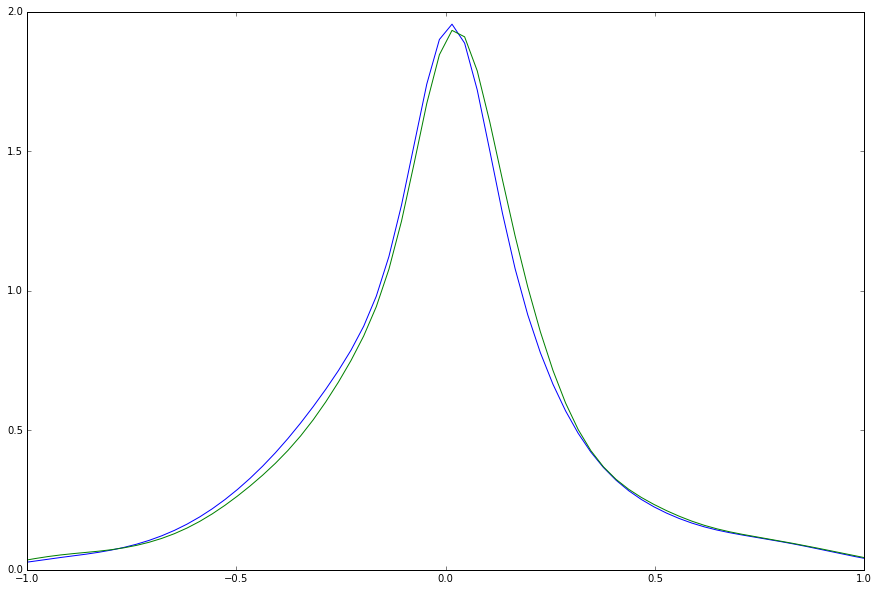

In [11]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1,1, figsize=(15,10))

density = gaussian_kde(data.Strokes_Gained.values)
xs = np.linspace(-3,3,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))

density = gaussian_kde(data['Strokes_Gained/Baseline'].values)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))

plt.xlim(-1,1)

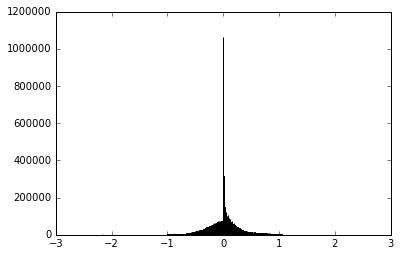

In [12]:
plt.hist(data.Strokes_Gained.values,bins=1000);

In [13]:
data.head()

,Year,Course_#,Round,Hole,Player_#,Strokes_Gained/Baseline,Hole_Score,Cat,Strokes_Gained,Difficulty_Start,Shots_taken_from_location,Shot
0,2004,35,1,1,1003,-0.119,5,Tee Box,-0.150016,4.818182,5,1
1,2004,35,1,1,1003,0.045,5,Primary Rough,0.145157,3.968198,4,2
2,2004,35,1,1,1003,0.026,5,Fairway,0.001619,2.823040,3,3
3,2004,35,1,1,1003,-0.220,5,Green,-0.216153,1.821421,2,4
4,2004,35,1,1,1003,0.045,5,Green,0.037574,1.037574,1,5


In [14]:
np.mean((data.Shots_taken_from_location-data.Difficulty_Start)**2)**.5

0.4965134141290478

In [15]:
data.insert(len(data.columns),'Difficulty_Start_adam',[0]*len(data))
data.loc[data.Shot==data.Hole_Score,'Difficulty_Start_adam'] = data[data.Shot==data.Hole_Score].Strokes_Gained + 1
data=data.sort_values(['Year','Player_#','Course_#','Round','Hole'])
for i in range(1,int(data.Hole_Score.max())+1): ##i is hole_score
    for j in range(i-1,0,-1): ##j is shot
        data.loc[(data.Hole_Score==i) & (data.Shot==j),'Difficulty_Start_adam'] = \
                                data[(data.Hole_Score==i) & (data.Shot==j+1)].Difficulty_Start_adam.values +\
                                data[(data.Hole_Score==i) & (data.Shot==j)].Strokes_Gained.values + 1

In [16]:
np.mean((data.Shots_taken_from_location-data.Difficulty_Start_adam)**2)**.5

0.49651341412904787

In [17]:
#data = data.drop('Difficulty_Start_broadie',axis=1)
data.insert(len(data.columns),'Difficulty_Start_broadie',[0]*len(data))

In [18]:
data.loc[data.Shot==data.Hole_Score,'Difficulty_Start_broadie'] = data[data.Shot==data.Hole_Score]['Strokes_Gained/Baseline'] + 1

In [19]:
data=data.sort_values(['Year','Player_#','Course_#','Round','Hole'])
for i in range(1,int(data.Hole_Score.max())+1): ##i is hole_score
    for j in range(i-1,0,-1): ##j is shot
        data.loc[(data.Hole_Score==i) & (data.Shot==j),'Difficulty_Start_broadie'] = \
                                data[(data.Hole_Score==i) & (data.Shot==j+1)].Difficulty_Start_broadie.values +\
                                data[(data.Hole_Score==i) & (data.Shot==j)]['Strokes_Gained/Baseline'].values + 1

In [20]:
np.mean((data.Shots_taken_from_location-data.Difficulty_Start_broadie)**2)**.5

0.5024583995993779

Seeing if adding average of all data for tee difficulties in raw data helps. (It doesn't, strangely)

In [21]:
data.insert(len(data.columns),'New_Difficulty',data.Difficulty_Start)

In [22]:
import pickle
with open('./../PickleFiles/TeeDifficulty.pkl','r') as pickleFile:
    d = pickle.load(pickleFile)

In [23]:
years = [key[0] for key in d.keys()]
courses = [key[1] for key in d.keys()]
holes = [key[2] for key in d.keys()]
round = [key[3] for key in d.keys()]
difficulties = [d[key] for key in d.keys()]
df = pd.DataFrame({'Year':years,'Course_#':courses,'Hole':holes,'Round':round,'Tee_Difficulty':difficulties})

In [24]:
df.shape

(45702, 5)

In [25]:
df.head()

,Course_#,Hole,Round,Tee_Difficulty,Year
0,202,6,2,4.562500,2004
1,205,15,1,2.846154,2014
2,656,11,1,3.294118,2007
3,776,16,4,3.986301,2014
4,4,16,4,3.240506,2011


In [26]:
data = pd.merge(data, df, on=['Course_#','Hole','Round','Year'])

In [27]:
data.loc[data.Shot==1,'New_Difficulty'] = data.loc[data.Shot==1,'Tee_Difficulty']

In [28]:
np.mean((data.Shots_taken_from_location-data.New_Difficulty)**2)**.5

0.49780691488172024

In [29]:
data.New_Difficulty.describe()

count    12356513.000000
mean            2.549799
std             1.136017
min             0.989376
25%             1.552459
50%             2.583098
75%             3.373390
max             5.518519
Name: New_Difficulty, dtype: float64

Bootstapped sample distributions of root mean squared errors

In [26]:
a = data.sample(frac=1,replace=True)

In [28]:
np.mean((a.Difficulty_Start_adam - a.Shots_taken_from_location)**2)**.5

0.4965214027761509

In [29]:
np.mean((a.Difficulty_Start_broadie - a.Shots_taken_from_location)**2)**.5

0.5024638721289336

In [31]:
def get_sample_dists(its):
    adam,broadie = [],[]
    for _ in xrange(its):
        print _
        a = data.sample(frac=1,replace=True)
        adam.append(np.mean((a.Difficulty_Start_adam - a.Shots_taken_from_location)**2)**.5)
        broadie.append(np.mean((a.Difficulty_Start_broadie - a.Shots_taken_from_location)**2)**.5)
    return adam,broadie

In [40]:
adam,broadie = get_sample_dists(1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

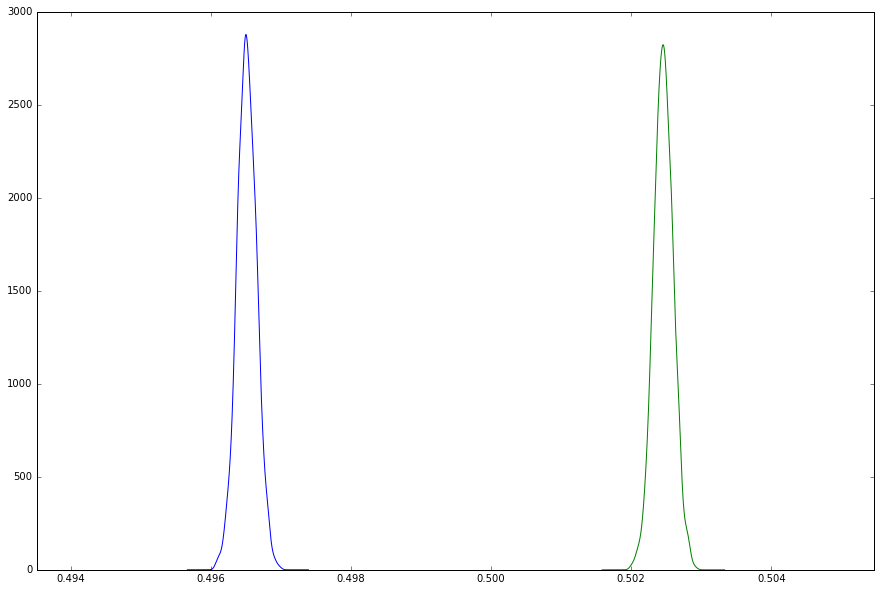

In [52]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1,1, figsize=(15,10))

density = gaussian_kde(adam)
xs = np.linspace(np.amin(adam)-3*np.std(adam),np.amax(adam)+3*np.std(adam),1000)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))

density = gaussian_kde(broadie)
xs = np.linspace(np.amin(broadie)-3*np.std(broadie),np.amax(broadie)+3*np.std(broadie),1000)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))

plt.xlim(np.mean(adam)-.003,np.mean(broadie)+.003);

In [55]:
np.percentile(adam,[2.5,97.5]),np.percentile(broadie,[2.5,97.5])

(array([ 0.49623565,  0.49679677]), array([ 0.50219151,  0.502734  ]))